In [53]:
# Install necessary libraries
!pip install -q sentence-transformers category_encoders xgboost shap matplotlib seaborn scikit-learn pandas numpy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [54]:
import os
import re
import json
import time
import warnings
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
from sentence_transformers import SentenceTransformer
import shap
import torch

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## 2. Data Loading & Pre-processing Functions

In [55]:
DATA_DIR = "/kaggle/input/dataeng"

def load_data(data_dir: str = DATA_DIR):
    """Load restaurants, reviews, users and dining trends into DataFrames."""
    if not os.path.isdir(data_dir):
        raise FileNotFoundError(
            f"Data directory '{data_dir}' does not exist. "
            "Please ensure the 'data' folder is present or update DATA_DIR."
        )

    print(f"📂 Loading data from {data_dir}...")
    with open(os.path.join(data_dir, "restaurant.json"), "r") as f:
        restaurant_data = json.load(f)
    df_restaurants = pd.DataFrame(restaurant_data)

    df_reviews = pd.read_csv(os.path.join(data_dir, "reviews.csv"))
    df_users = pd.read_csv(os.path.join(data_dir, "user_data.csv"))
    df_trends = pd.read_csv(os.path.join(data_dir, "dining_trends.csv"))

    print(
        "✅ Data loaded:",
        f"restaurants={df_restaurants.shape},",
        f"reviews={df_reviews.shape},",
        f"users={df_users.shape},",
        f"trends={df_trends.shape}",
    )
    return df_restaurants, df_reviews, df_users, df_trends


def parse_price_range_to_avg(price_str):
    """
    Convert 'AED 150 - 200' → 175.0.
    Returns NaN if parsing fails.
    """
    if pd.isna(price_str):
        return np.nan
    s = str(price_str)
    # Remove currency prefix and non-digit / non-hyphen chars
    s = re.sub(r"[^\d\-]", " ", s)
    match = re.search(r"(\d+)\s*-\s*(\d+)", s)
    if match:
        low, high = float(match.group(1)), float(match.group(2))
        return (low + high) / 2.0
    return np.nan


# Exact mapping from restaurant price_range to user-style buckets
PRICE_BUCKET_MAP = {
    "AED 50 - 100": "Low",
    "AED 100 - 150": "Medium",
    "AED 150 - 200": "High",
    "AED 200 - 300+": "Luxury",
}

def map_restaurant_price_bucket(price_str: str) -> str:
    """Map raw restaurant price_range to one of: Low / Medium / High / Luxury / Unknown."""
    if pd.isna(price_str):
        return "Unknown"
    return PRICE_BUCKET_MAP.get(str(price_str), "Unknown")


def tokenizer_splitter(text):
    """Split a comma-separated string into a clean list of tokens."""
    if pd.isna(text):
        return []
    return [t.strip() for t in str(text).split(",") if t.strip()]


# Load all base tables
df_restaurants, df_reviews, df_users, df_trends = load_data()

📂 Loading data from /kaggle/input/dataeng...
✅ Data loaded: restaurants=(50, 12), reviews=(1000, 7), users=(1000, 9), trends=(7310, 9)


## 3. Time-Series Feature Engineering (The Core Upgrade)

In [56]:
print("Starting time-series feature engineering...")

# Ensure correct data types and stable ordering
df_trends['date'] = pd.to_datetime(df_trends['date'])
df_trends = df_trends.sort_values(['cuisine_type', 'date']).reset_index(drop=True)

# Group by cuisine_type for all rolling / lag operations
grouped_pop = df_trends.groupby('cuisine_type')['popularity_score']
grouped_price = df_trends.groupby('cuisine_type')['avg_price']

# 1-step lag (yesterday's popularity)
df_trends['popularity_lag_1'] = grouped_pop.shift(1)

# Rolling averages using ONLY past data (shift before rolling)
df_trends['popularity_7_day_avg'] = grouped_pop.shift(1).rolling(7, min_periods=1).mean()
df_trends['popularity_30_day_avg'] = grouped_pop.shift(1).rolling(30, min_periods=1).mean()

df_trends['avg_price_7_day_avg'] = grouped_price.shift(1).rolling(7, min_periods=1).mean()

# 7‑day momentum: compare yesterday vs. 7 days ago
prev_7 = grouped_pop.shift(7)
growth = (df_trends['popularity_lag_1'] - prev_7) / prev_7.replace(0, np.nan)

# Clean up NaNs / inf from division
growth = growth.replace([np.inf, -np.inf], 0).fillna(0)
df_trends['popularity_7_day_growth'] = growth

print("Time-series features created:")
print(
    df_trends[
        ['date', 'cuisine_type', 'popularity_score',
         'popularity_7_day_avg', 'popularity_30_day_avg',
         'popularity_lag_1', 'avg_price_7_day_avg',
         'popularity_7_day_growth']
    ].head()
)

Starting time-series feature engineering...
Time-series features created:
        date cuisine_type  popularity_score  popularity_7_day_avg  \
0 2023-11-19      Chinese             69.77                   NaN   
1 2023-11-20      Chinese             71.07                 69.77   
2 2023-11-21      Chinese             65.89                 70.42   
3 2023-11-22      Chinese             56.67                 68.91   
4 2023-11-23      Chinese             54.69                 65.85   

   popularity_30_day_avg  popularity_lag_1  avg_price_7_day_avg  \
0                    NaN               NaN                  NaN   
1                  69.77             69.77           176.860000   
2                  70.42             71.07           150.805000   
3                  68.91             65.89           148.796667   
4                  65.85             56.67           145.800000   

   popularity_7_day_growth  
0                      0.0  
1                      0.0  
2                    

## 4. Data Merging & Final Feature Engineering

In [57]:
print("Merging tables and engineering interaction features...")

# Ensure date type
df_reviews['date'] = pd.to_datetime(df_reviews['date'])
df_trends['date'] = pd.to_datetime(df_trends['date'])

# Core merge: reviews + restaurants + users + trends (by date & cuisine)
df_merged = (
    df_reviews
    .merge(df_restaurants.add_prefix("resto_"), left_on="restaurant_id", right_on="resto_id", how="left")
    .merge(df_users, on="user_id", how="left")
    .merge(df_trends, left_on=["date", "resto_cuisine"], right_on=["date", "cuisine_type"], how="left")
)

# ---------- PRICE FEATURES ----------
# Numeric restaurant price
df_merged['price_avg'] = df_merged['resto_price_range'].apply(parse_price_range_to_avg)
# Categorical bucket aligned with user pref (Low / Medium / High / Luxury)
df_merged['resto_price_bucket'] = df_merged['resto_price_range'].apply(map_restaurant_price_bucket)

def price_alignment(row):
    """1 if user's preferred_price_range matches restaurant price bucket, else 0."""
    user_pref = str(row['preferred_price_range']).strip().lower()
    resto_bucket = str(row['resto_price_bucket']).strip().lower()
    if user_pref in ["", "nan"] or resto_bucket == "unknown":
        return 0
    return int(user_pref == resto_bucket)

df_merged['price_alignment_score'] = df_merged.apply(price_alignment, axis=1)

# ---------- CUISINE PREFERENCE FEATURES ----------
# Normalize favorite cuisines & restaurant cuisine
df_merged['favorite_cuisines'] = df_merged['favorite_cuisines'].fillna('').astype(str)
df_merged['favorite_cuisines_list'] = (
    df_merged['favorite_cuisines']
    .str.lower()
    .apply(lambda s: [c.strip() for c in s.split(',') if c.strip()])
)
df_merged['resto_cuisine_lower'] = df_merged['resto_cuisine'].str.lower()

def cuisine_match(row):
    return int(row['resto_cuisine_lower'] in row['favorite_cuisines_list'])

df_merged['user_cuisine_match'] = df_merged.apply(cuisine_match, axis=1)

# ---------- DIETARY CONSTRAINT FEATURES ----------
def dietary_conflict(row):
    """1 if user has a restriction that is NOT clearly supported by restaurant attrs/amenities."""
    restriction = str(row['dietary_restrictions']).lower()
    attrs = (str(row['resto_attributes']) + " " + str(row['resto_amenities'])).lower()

    if restriction in ["nan", "none", "", "no"]:
        return 0

    if 'vegan' in restriction and 'vegan' not in attrs:
        return 1
    if 'vegetarian' in restriction and 'vegetarian' not in attrs:
        return 1
    if 'gluten' in restriction and 'gluten' not in attrs:
        return 1
    if 'halal' in restriction and 'halal' not in attrs:
        return 1

    return 0

df_merged['dietary_conflict'] = df_merged.apply(dietary_conflict, axis=1)

# ---------- USER LOCATION FEATURES ----------
df_merged['is_local_resident'] = (df_merged['home_location'] == df_merged['resto_location']).astype(int)

# ---------- DATE-BASED FEATURES ----------
df_merged['review_month'] = df_merged['date'].dt.month.astype('int8')
df_merged['review_day_of_week'] = df_merged['date'].dt.dayofweek.astype('int8')

# ---------- TEXT NA HANDLING ----------
for col in ['resto_amenities', 'resto_attributes', 'resto_description', 'review_text']:
    df_merged[col] = df_merged[col].fillna('')

print(f"Merged Data Shape: {df_merged.shape}")

Merging tables and engineering interaction features...
Merged Data Shape: (1000, 50)


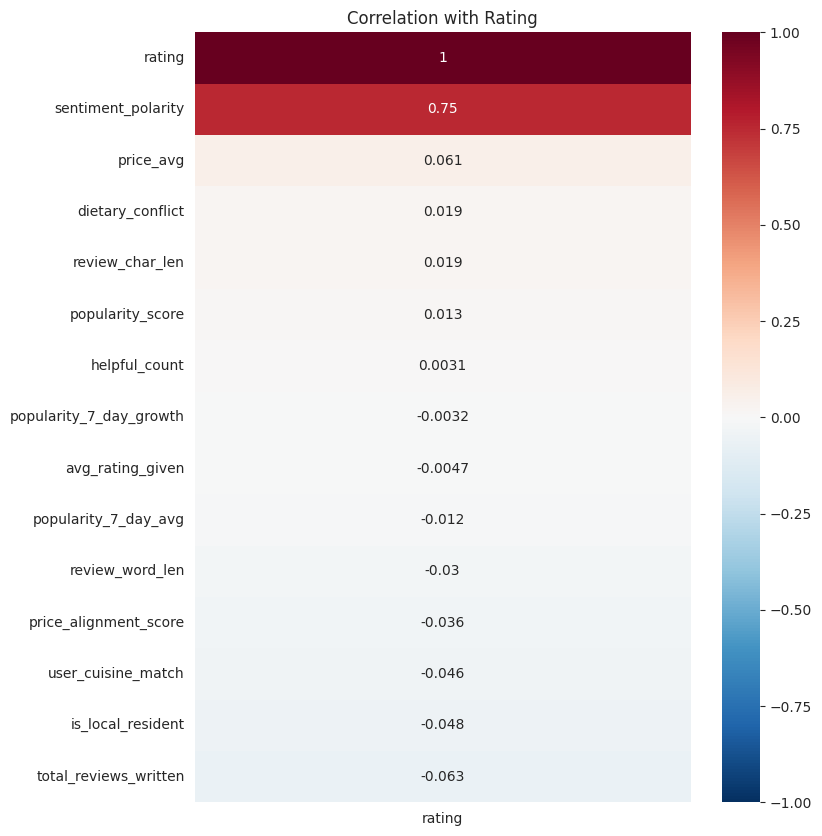

In [58]:
   # After df_merged is constructed

   from textblob import TextBlob

   # sentiment + simple text stats
   df_merged["sentiment_polarity"] = df_merged["review_text"].astype(str).apply(
       lambda x: TextBlob(x).sentiment.polarity
   )
   df_merged["review_char_len"] = df_merged["review_text"].astype(str).str.len()
   df_merged["review_word_len"] = df_merged["review_text"].astype(str).str.split().str.len()

   # correlation only on interpretable columns – no embeddings here
   cols_to_corr = [
       "rating",
       "sentiment_polarity",
       "review_char_len",
       "review_word_len",
       "helpful_count",
       "avg_rating_given",
       "total_reviews_written",
       "price_avg",
       "price_alignment_score",
       "user_cuisine_match",
       "dietary_conflict",
       "is_local_resident",
       "popularity_score",
       "popularity_7_day_avg",
       "popularity_7_day_growth",
   ]

   corr = df_merged[cols_to_corr].corr(method="spearman")
   plt.figure(figsize=(8, 10))
   sns.heatmap(corr[["rating"]].sort_values("rating", ascending=False),
               annot=True, cmap="RdBu_r", vmin=-1, vmax=1)
   plt.title("Correlation with Rating")
   plt.show()

## 5. ⚡ GPU-Accelerated Embedding Generation (Run Once)

In [59]:
# 5. ⚡ GPU-Accelerated Embedding Generation (Run Once)

MODEL_NAME = "Qwen/Qwen3-Embedding-0.6B"
print(f"Loading embedding model: {MODEL_NAME} on {device}...")

# trust_remote_code is required for new Qwen models
embedder = SentenceTransformer(
    MODEL_NAME,
    trust_remote_code=True,
    device=device
)

print("Generating embeddings for all reviews (this runs once)...")
start_t = time.time()

# Convert to list once; keep order aligned with df_merged index
review_texts = df_merged['review_text'].astype(str).tolist()

embeddings_matrix = embedder.encode(
    review_texts,
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True  # keeps scales stable
)

end_t = time.time()
print(f"✅ Embeddings generated in {end_t - start_t:.2f} seconds.")

embedding_dim = embeddings_matrix.shape[1]
embedding_cols = [f"embed_{i}" for i in range(embedding_dim)]

embedding_df = pd.DataFrame(
    embeddings_matrix,
    columns=embedding_cols,
    index=df_merged.index
)

# df_final = merged structured features + embedding features
df_final = pd.concat([df_merged, embedding_df], axis=1)
print(f"Added {embedding_dim} embedding features. Final shape: {df_final.shape}")

Loading embedding model: Qwen/Qwen3-Embedding-0.6B on cuda...
Generating embeddings for all reviews (this runs once)...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

✅ Embeddings generated in 6.03 seconds.
Added 1024 embedding features. Final shape: (1000, 1077)


In [60]:
# # --- PORTFOLIO-QUALITY VISUALIZATION BLOCK ---
# import seaborn as sns
# import matplotlib.pyplot as plt
# from textblob import TextBlob

# # Set professional style
# sns.set_style("whitegrid")
# plt.rcParams['font.family'] = 'sans-serif'

# # 1. Compute Sentiment (if not already done)
# if 'sentiment_polarity' not in df_merged.columns:
#     print("Computing sentiment...")
#     df_merged['sentiment_polarity'] = df_merged['review_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# # --- PLOT 1: The "Truth" of Reviews (Sentiment vs. Rating) ---
# # Goal: Show that your text processing is actually working.
# plt.figure(figsize=(10, 6))
# sns.violinplot(x='rating', y='sentiment_polarity', data=df_merged, palette='viridis', inner='quartile')
# plt.title('Do Higher Ratings Actually Mean More Positive Text?', fontsize=14, fontweight='bold')
# plt.xlabel('User Star Rating')
# plt.ylabel('Text Sentiment Polarity (-1 to +1)')
# plt.axhline(0, color='black', linestyle='--', alpha=0.3) # Zero line
# plt.tight_layout()
# plt.show()

# # --- PLOT 2: The "Bias" Check (User Habits vs. Rating) ---
# # Goal: Show you understand user bias (Are frequent diners harsher?)
# plt.figure(figsize=(10, 6))
# # Bin 'total_reviews_written' to make it readable
# df_merged['reviewer_experience'] = pd.cut(df_merged['total_reviews_written'], 
#                                           bins=[0, 5, 20, 50, 1000], 
#                                           labels=['Newbie', 'Casual', 'Regular', 'Power User'])

# sns.pointplot(x='reviewer_experience', y='rating', hue='price_tier', 
#               data=df_merged, dodge=True, palette='deep', errorbar=None)
# plt.title('Are "Power Users" Harsher Critics?', fontsize=14, fontweight='bold')
# plt.xlabel('Reviewer Experience Level')
# plt.ylabel('Average Rating Given')
# plt.legend(title='Restaurant Price Tier')
# plt.tight_layout()
# plt.show()

# # --- PLOT 3: The "Trend" Impact (Popularity Momentum) ---
# # Goal: Show that your time-series engineering matters.
# plt.figure(figsize=(10, 6))
# # Create a simplified momentum bin
# df_merged['momentum_category'] = pd.cut(df_merged['popularity_7_day_growth'], 
#                                         bins=[-1, -0.05, 0.05, 1], 
#                                         labels=['Trending Down', 'Stable', 'Trending Up'])

# sns.barplot(x='momentum_category', y='rating', data=df_merged, palette='rocket', capsize=.1)
# plt.title('Does Cuisine Momentum Affect Ratings?', fontsize=14, fontweight='bold')
# plt.xlabel('Cuisine Popularity Trend (7-Day)')
# plt.ylabel('Average Rating')
# plt.tight_layout()
# plt.show()

## 6. Pipeline Setup & Training

In [61]:
# 6. Feature Lists, Train/Test Split, and Preprocessing

target_col = "rating"
y = df_final[target_col]

# ---- NUMERICAL FEATURES ----
numerical_features = [
    # Review-level
    "helpful_count",
    # User profile
    "age", "avg_rating_given", "total_reviews_written",
    # Dining trends (level & momentum)
    "popularity_score", "avg_price", "booking_lead_time_days",
    "popularity_7_day_avg", "popularity_30_day_avg", "popularity_lag_1",
    "avg_price_7_day_avg", "popularity_7_day_growth",
    # Restaurant pricing
    "price_avg", "price_alignment_score",
    # User–restaurant alignment
    "user_cuisine_match", "dietary_conflict", "is_local_resident"
]

# ---- CATEGORICAL FEATURES ----
categorical_features = [
    # Restaurant
    "resto_location", "resto_cuisine", "resto_price_bucket",
    # User
    "home_location", "preferred_price_range", "dietary_restrictions", "dining_frequency",
    # Context
    "season", "day_type", "weather_impact_category",
    # Calendar
    "review_month", "review_day_of_week",
    # Holiday flag
    "is_holiday"
]

desc_feature = "resto_description"
amenities_feature = "resto_amenities"
attributes_feature = "resto_attributes"

valid_mask = y.notna()
cols_to_keep = (
    numerical_features
    + categorical_features
    + [desc_feature, amenities_feature, attributes_feature]
    + embedding_cols
)

X = df_final.loc[valid_mask, cols_to_keep]
y = y[valid_mask]

# Sample weights: give more importance to reviews marked helpful by many users
# (log1p to avoid extreme dominance)
sample_weight = 1.0 + np.log1p(df_final.loc[valid_mask, "helpful_count"])

print(f"Training Data Shape: {X.shape}")

X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, sample_weight, test_size=0.2, random_state=42
)

# Preprocessing Pipeline
numerical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

desc_transformer = TfidfVectorizer(max_features=100, stop_words="english", ngram_range=(1, 2))
amenities_transformer = CountVectorizer(tokenizer=tokenizer_splitter, token_pattern=None, max_features=50)
attributes_transformer = CountVectorizer(tokenizer=tokenizer_splitter, token_pattern=None, max_features=50)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
        ("embed", "passthrough", embedding_cols),
        ("desc", desc_transformer, desc_feature),
        ("amenities", amenities_transformer, amenities_feature),
        ("attributes", attributes_transformer, attributes_feature),
    ],
    remainder="drop",
)

Training Data Shape: (1000, 1057)


## 7. Heavy Model Training, Evaluation & SHAP
This part remains the same, as the pipeline structure is robust enough to handle the new features without changes.

In [62]:
# 7. XGBoost Training, Evaluation & Saving

import warnings
from pprint import pprint

warnings.filterwarnings(
    "ignore",
    message=".*Falling back to prediction using DMatrix.*",
    category=UserWarning,
    module="xgboost.core"
)

xgb_model = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    device=device,
    random_state=SEED,
)

param_distributions = {
    "regressor__n_estimators": [400, 600, 800],
    "regressor__max_depth": [4, 6, 8],
    "regressor__learning_rate": [0.01, 0.03, 0.05],
    "regressor__subsample": [0.8, 0.9, 1.0],
    "regressor__colsample_bytree": [0.7, 0.8, 1.0],
    "regressor__min_child_weight": [1, 3, 5],
    "regressor__gamma": [0, 0.1, 0.3],
}

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", xgb_model),
    ]
)

search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=15,
    cv=3,
    scoring="neg_mean_squared_error",
    verbose=1,
    random_state=SEED,
    n_jobs=-1,
)

print("🚀 Starting optimized XGBoost training...")
start_time = time.time()

# Pass sample weights to the regressor inside the pipeline
search.fit(X_train, y_train, regressor__sample_weight=sw_train)

train_duration = time.time() - start_time
best_model = search.best_estimator_

print(f"\nBest hyperparameters found:")
pprint(search.best_params_)

# ---- Evaluation on Test Set ----
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 Test Performance (XGBoost)")
print(f"R²   : {r2:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"Training time: {train_duration:.1f} seconds")

# ---- Save model ----
model_path = "best_restaurant_rating_model_xgboost.pkl"
joblib.dump(best_model, model_path)
print(f"\n💾 Model saved to: {model_path}")

🚀 Starting optimized XGBoost training...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best hyperparameters found:
{'regressor__colsample_bytree': 0.8,
 'regressor__gamma': 0.3,
 'regressor__learning_rate': 0.01,
 'regressor__max_depth': 8,
 'regressor__min_child_weight': 5,
 'regressor__n_estimators': 800,
 'regressor__subsample': 0.9}

📊 Test Performance (XGBoost)
R²   : 0.8837
RMSE : 0.4799
MAE  : 0.3788
Training time: 98.7 seconds

💾 Model saved to: best_restaurant_rating_model_xgboost.pkl


Booster features: 1237, built names: 1237


<Figure size 1000x1000 with 0 Axes>

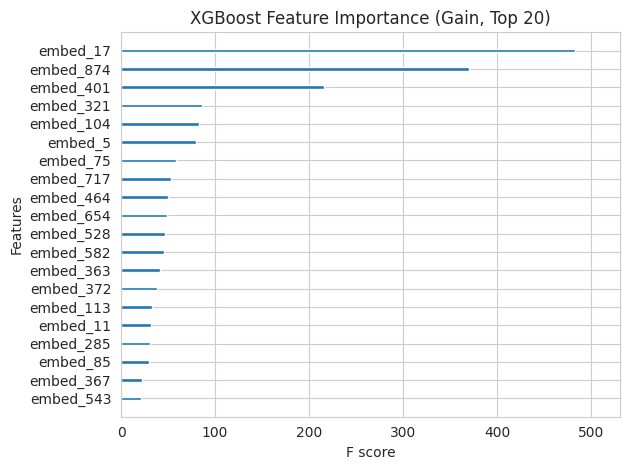

<Figure size 1800x1000 with 0 Axes>

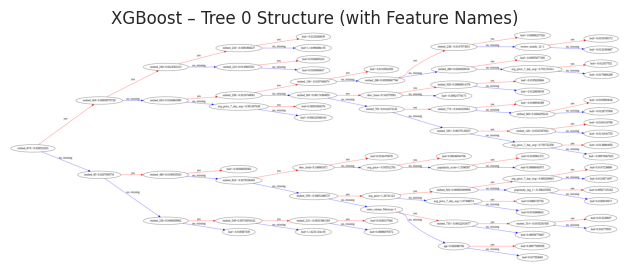

In [63]:
# 8. XGBoost Feature Names + Diagrams (Readable)

from xgboost import plot_importance, plot_tree

# 1) Extract trained pieces
prep = best_model.named_steps["preprocessor"]
reg = best_model.named_steps["regressor"]
booster = reg.get_booster()

# 2) Rebuild feature names in the same order as the transformed matrix

feature_names = []

# a) Numerical features (pass through scaler, same order)
feature_names.extend(numerical_features)

# b) Categorical features (after OneHotEncoder)
cat_pipeline = prep.named_transformers_["cat"]
ohe = cat_pipeline.named_steps["onehot"]
feature_names.extend(ohe.get_feature_names_out(categorical_features).tolist())

# c) Embedding dimensions
feature_names.extend(embedding_cols)  # 'embed_0', 'embed_1', ...

# d) Description TF‑IDF
desc_vec = prep.named_transformers_["desc"]
feature_names.extend([f"desc_{t}" for t in desc_vec.get_feature_names_out()])

# e) Amenities / Attributes BoW
amen_vec = prep.named_transformers_["amenities"]
attr_vec = prep.named_transformers_["attributes"]
feature_names.extend([f"amen_{t}" for t in amen_vec.get_feature_names_out()])
feature_names.extend([f"attr_{t}" for t in attr_vec.get_feature_names_out()])

print(f"Booster features: {booster.num_features()}, built names: {len(feature_names)}")

# Attach names so XGBoost plots use them instead of f0, f1, ...
booster.feature_names = feature_names

# 3) Feature Importance (Top 20, human-readable)
plt.figure(figsize=(10, 10))
plot_importance(
    booster,
    max_num_features=20,
    importance_type="gain",
    show_values=False
)
plt.title("XGBoost Feature Importance (Gain, Top 20)")
plt.tight_layout()
plt.show()

# 4) Single tree diagram (Tree 0) with real feature names
plt.figure(figsize=(18, 10))
plot_tree(
    booster,
    num_trees=0,            # first tree
    rankdir="LR"            # left-to-right layout
)
plt.title("XGBoost – Tree 0 Structure (with Feature Names)")
plt.tight_layout()
plt.show()

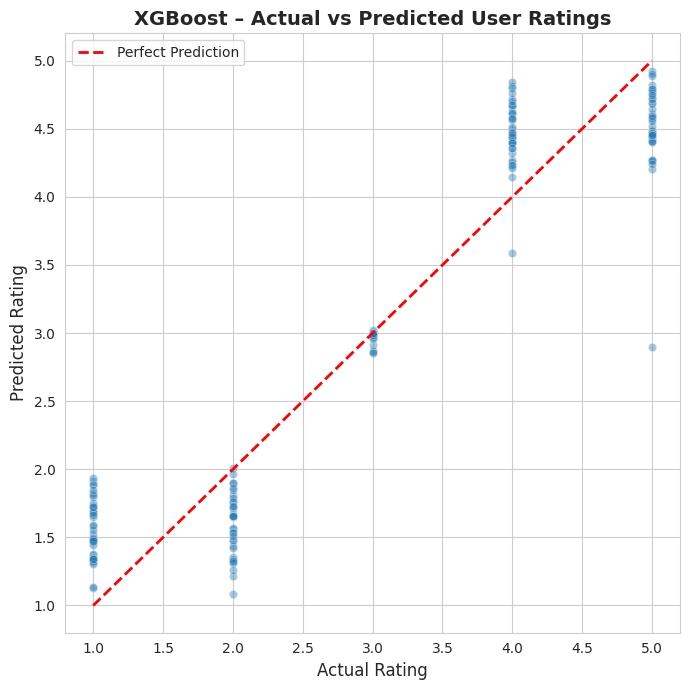

In [64]:
# 9. Actual vs Predicted Plot (XGBoost)

plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", lw=2, label="Perfect Prediction")

plt.xlabel("Actual Rating", fontsize=12)
plt.ylabel("Predicted Rating", fontsize=12)
plt.title("XGBoost – Actual vs Predicted User Ratings", fontsize=14, fontweight="bold")
plt.legend()
plt.tight_layout()
plt.show()